# GARLIC demo

General-purpose Adaptive Richardson-Lucy Image Characterisation

# 1. Initialisation

## Import libraries and scripts

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import ipywidgets as widgets
from IPython.display import display

import numpy as np
from time import time
from scipy import ndimage

import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded
> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

Plotting:

In [2]:
def new_figure(fig_name, figsize=(10, 5), nrows=1, ncols=1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}):
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=figsize)
    axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                        sharex=sharex, sharey=sharey,
                        gridspec_kw=gridspec_kw
                       )
    fig.set_tight_layout(True)
    for ax in axes.flat:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

    fig.suptitle(fig_name)
    
    return fig, axes

In [3]:
default_cmap = plt.get_cmap("gist_earth").copy()
default_cmap.set_bad('gray')


def colour_map(ax, cblabel, data, cmap=default_cmap, norm=None, xlabel=None, x=None, ylabel=None, y=None):
    
    if norm is None:
        percentiles = np.array([1, 16, 50, 84, 99])
        ticks = np.nanpercentile(data, percentiles)
        linthresh = np.median(data[data > 0])
        norm = colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=linthresh)
    else:
        ticks = None
    if y is None:
        y = np.arange(data.shape[0])
    if x is None:
        x = np.arange(data.shape[1])

    im = ax.imshow(data,
                   extent=(x[0]-(x[1]-x[0])/2, x[-1]+(x[-1]-x[-2])/2, y[0]-(y[1]-y[0])/2, y[-1]+(y[-1]-y[-2])/2),
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    #ax.set_aspect('auto')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(cblabel)
    if ticks is not None:
        cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)])
    cb.ax.tick_params(labelsize='small')
    
    return im, cb


## Read data

In [4]:
importlib.reload(scripts.read_data)
object_name, data, true_spectrum = scripts.read_data.run(12, (0, 0, 1))
data_offset = np.nanmin(data)

Read dataset 12: "Tobias' datacube" (175,) (0.0066 s)


## Parameter settings

In [5]:
residual_accuracy = .1
max_iter = 100  # in principle, just for safety

# 2. Diffuse emission

In [6]:
importlib.reload(scripts.multiscale_RL)
compact_scale, diffuse_scale, background, residual_above_bg = scripts.diffuse_emission.run(data)
smoothing_radii = np.array([1, compact_scale, diffuse_scale])
mRL = scripts.multiscale_RL.run((data - background).clip(min=0), smoothing_radii, .05)

60 minima => smoothing_scale = 5.8 pixels
   median absolute residual = 5.398e-02, bg_fluctuations = 1.336e-01
32 minima => smoothing_scale = 10.9 pixels
   median absolute residual = 7.225e-02, bg_fluctuations = 4.331e-02
mean/median background = -1.691e-01/-1.727e-01,  residual = 1.891e-01/1.876e-01 (0.00237 s)
iteration 1/100: rms_residual = 1.30e-01 (+98.05%)
iteration 2/100: rms_residual = 1.17e-01 (-11.26%)
iteration 3/100: rms_residual = 1.09e-01 (-6.84%)
iteration 4/100: rms_residual = 1.04e-01 (-4.74%)
Multiscale Richardson-Lucy deconvolution (0.00245 s)


In [7]:
compact_emission = ndimage.gaussian_filter(mRL[0], 1) + ndimage.gaussian_filter(mRL[1], compact_scale)
diffuse_residual = ndimage.gaussian_filter(mRL[2], diffuse_scale)
model_emission = background + diffuse_residual + compact_emission
diffuse_emission = background + diffuse_residual

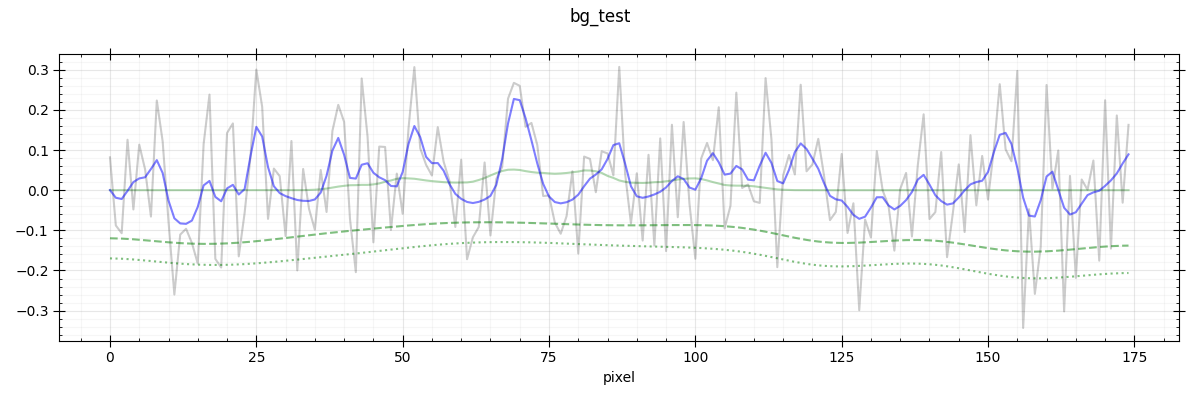

In [11]:
fig_name = 'bg_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12,4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False)
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
ax.grid(True, which='both')

ax.plot(true_spectrum, 'g-', alpha=.3)
ax.plot(data, 'k-', alpha=.2)

#ax.plot(estimate, 'r-', alpha=.2)
#ax.plot(np.arange(data.size)[index_minima], estimate[index_minima], 'k+')

ax.plot(model_emission, 'b-', alpha=.5)
ax.plot(diffuse_emission, 'g--', alpha=.5)
#ax.fill_between(np.arange(data.size), diffuse_emission - mean_below, diffuse_emission + mean_below, color='g', alpha=.1)
ax.plot(background, 'g:', alpha=.5)

ax.set_xlabel('pixel')
#ax.set_xlim(5900, 6300)
#ax.set_ylim(np.min(background-(diffuse_emission-background)), np.max(diffuse_emission+2*(diffuse_emission-background)))

#ax.plot(diffuse_weight, 'g--', alpha=.5)
#ax.set_ylim(0, 1)

plt.show()


In [ ]:
np.max(background+3*diffuse_emission), np.argmax(background+3*diffuse_emission), background[4046], diffuse_emission[4046]

# 3. Source finding

In [ ]:
mRL_estimate = np.zeros_like(boosted_sources)
for i, radius in enumerate(smoothing_radii):
    mRL_estimate += ndimage.gaussian_filter(mRL[i], radius)
rms_residual = np.std(boosted_sources - mRL_estimate)
print(rms_residual, np.nanstd(mRL_estimate.flat[1:]-mRL_estimate.flat[:-1])/np.sqrt(2), np.nanstd(data.flat[1:]-data.flat[:-1])/np.sqrt(2))

## Hierarchical Overdensity Tree

In [ ]:
importlib.reload(scripts.sort_data)
#argsorted_data, n_valid = scripts.sort_data.run(RL.ravel())
argsorted_data, n_valid = scripts.sort_data.run(mRL.ravel())

In [ ]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(mRL.strides)//mRL.itemsize, mRL.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
HOT_labels, HOT_catalog = scripts.HOT.run(mRL, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

In [ ]:
HOT_parent = HOT_catalog[0]
HOT_area = HOT_catalog[1]
HOT_test_stat = HOT_catalog[2]
HOT_bg = HOT_catalog[3]
#max_test_stat = catalog[3]

## Individual sources

In [ ]:
def get_individual_mRL(mRL, labels, target):

    mRL_target = np.zeros_like(mRL)
    indices = np.where(labels == target)
    mRL_target[indices] = mRL[indices]
    '''
    RL[target] = mRL[target] - bg[lbl]
    children = np.where(parent == lbl)[0]
    for child in np.unique(children[children != lbl]):
        print(child, bg[child], bg[lbl])
        target = np.where((self.label == child) | (parent[self.label] == child))
        RL[target] = bg[child] - bg[lbl]
    '''
    return mRL_target

# 3. Plots

Normalisation and color maps:

In [ ]:
n_sources = np.unique(HOT_labels).size
latin_cube = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
latin_cube[0, :] = [0., 0., 0., 1.]  # background object must be black :^)
label_cmap = colors.ListedColormap(latin_cube)
label_norm = colors.Normalize(vmin=-.5, vmax=n_sources+.5)
print(f'{n_sources} unique sourcces')

In [ ]:
mRL_cmap = default_cmap
mRL_norm = colors.LogNorm(vmin=np.percentile(mRL[mRL>0], 10), vmax=np.percentile(mRL[mRL>0], 99))

In [ ]:
fig_name = 'GARLIC_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=3, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .02], 'hspace': 0})
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
#im = ax.imshow(label[np.newaxis, :],
im = ax.imshow(HOT_labels,
               interpolation='nearest', origin='lower', cmap=label_cmap, norm=label_norm,
              )
ax.set_aspect('auto')
ax.set_ylabel('smoothing scale')
ax.set_yticks(np.arange(smoothing_radii.size), [f'{radius:.3g}' for radius in smoothing_radii])
cb = plt.colorbar(im, cax=axes[0, 1], orientation='vertical', shrink=.9)
cb.ax.tick_params(labelsize='small')
cb.ax.set_ylabel('source ID')


ax = axes[1, 0]
im = ax.imshow(mRL,
               interpolation='nearest', origin='lower', cmap=mRL_cmap, norm=mRL_norm,
              )
ax.set_aspect('auto')
ax.set_ylabel('smoothing scale')
ax.set_yticks(np.arange(smoothing_radii.size), [f'{radius:.3g}' for radius in smoothing_radii])
cb = plt.colorbar(im, cax=axes[1, 1], orientation='vertical', shrink=.9)
cb.ax.tick_params(labelsize='small')
cb.ax.set_ylabel('Richardson-Lucy intensity')

ax = axes[2, 0]
ax.set_ylabel('intensity')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
ax.grid(True, which='both')

ax.plot(true_spectrum, 'g-', alpha=.3)
ax.plot(data, 'k-', alpha=.2)
#ax.axhline(data_offset, c='r', ls=':', alpha=.5)
ax.plot(np.sum(mRL, axis=0) + background, 'r-', alpha=.5)
ax.plot(mRL_estimate + background, 'b-', alpha=.5)
ax.plot(background, 'y-', alpha=.5)
ax.plot(background + residual_above_bg, 'y:', alpha=.5)
ax.fill_between(np.arange(data.size), background, background+2*residual_above_bg, color='y', alpha=.1)

ax.plot(diffuse_emission + diffuse_offset, 'k-.', alpha=.5)
ax.plot(diffuse_emission, 'k--', alpha=.5)
#ax.plot(original_pixel, ndimage.gaussian_filter(mRL[0], smoothing_radii[0])+data_offset, 'g-', alpha=.5)
#ax.plot(original_pixel, 2*ndimage.gaussian_filter(mRL[-1], smoothing_radii[-1])+data_offset, 'y-', alpha=.5)


ax.set_xlabel('pixel ID')
#ax.set_xlim(5900, 6300)
#ax.set_ylim(-10, 300)
#ax.set_ylim(np.min(background)*.9, np.max(background+4*residual_above_bg))

axes[2, 1].axis('off')
plt.show()

In [ ]:
def get_mRL_inpaint(mRL, labels, target):

    mRL_target = np.zeros_like(mRL)
    indices = np.where(labels == target)
    mRL_target[indices] = mRL[indices]

    radius = np.sqrt(mRL.shape[0])
    inpaint_map = np.where(mRL_target > 0, 1., 0.)  # object mask
    inpaint_map = ndimage.gaussian_filter(inpaint_map, radius)  # interpolation weight
    inpaint_map = np.clip(inpaint_map, np.min(inpaint_map[inpaint_map > 0]), np.inf)  # to prevent division by zero
    inpaint_map = ndimage.gaussian_filter(mRL_target, radius) / inpaint_map

    return mRL_target, np.fmin(inpaint_map, mRL)


def get_individual_mRL(mRL, labels, parent, target):

    mRL_target, inpaint_map = get_mRL_inpaint(mRL, labels, target)
    
    # compute contribution to descendants:
    progenitor = parent[labels]
    if parent[target] == target:
        indices = np.where(labels == target)
        progenitor[indices] = 0
    n_found = 1
    while n_found > 0:
        indices = np.where(progenitor == target)
        n_found = len(indices[0])
        #print(f'{n_found} values painted')
        mRL_target[indices] = inpaint_map[indices]
        if parent[target] == target:
            progenitor[indices] = 0
        progenitor = parent[progenitor]

    # remove contribution from ancestors:
    '''
    RL[target] = mRL[target] - bg[lbl]
    '''

    return mRL_target


class Explore_lbl_1D(object):
    
    def __init__(self, fig_name, data, boosted_data, estimate, label, parent):
        """Interactive display"""
        
        plt.close(fig_name)
        self.fig = plt.figure(fig_name, figsize=(12, 7))
        self.axes = self.fig.subplots(nrows=4, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .02], 'hspace': 0})
        self.fig.suptitle(fig_name)
        self.fig.set_tight_layout(True)

        self.original = data
        self.boosted_data = boosted_data
        self.data_offset = np.nanmin(data)
        #self.RL = RL
        #self.SSF = SSF
        self.total_estimate = estimate
        self.label = label
        self.parent = parent

        self.ax_parent = self.axes[0, 0]
        self.ax_parent_cb = self.axes[0, 1]
        self.ax_lbl = self.axes[1, 0]
        self.ax_lbl_cb = self.axes[1, 1]

        self.ax_im = self.axes[2, 0]
        self.ax_cb = self.axes[2, 1]

        self.ax0 = self.axes[3, 0]
        self.ax0.plot(data, 'k-', alpha=.2)
        self.ax0.set_xlim(0, data.size)
        self.axes[3, 1].axis('off')

        self.widget = widgets.interactive(self.plot_lbl, lbl=widgets.BoundedIntText(value=1, min=1, max=n_sources, continuous_update=False))
        display(self.widget)


    def plot_lbl(self, lbl):
        xlim = self.ax0.get_xlim()
        ylim = self.ax0.get_ylim()

        ax = self.ax_parent
        im = ax.imshow(self.parent[self.label],
                       interpolation='nearest', origin='lower',
                       cmap=label_cmap, norm=colors.Normalize(vmin=-.5, vmax=n_sources+.5),
                      )
        ax.set_aspect('auto')
        ax.set_yticks(np.arange(smoothing_radii.size), [f'{radius:.3g}' for radius in smoothing_radii])
        cb = plt.colorbar(im, cax=self.ax_parent_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        cb.ax.set_ylabel('parent ID')
        
        
        ax = self.ax_lbl
        im = ax.imshow(self.label,
                       interpolation='nearest', origin='lower',
                       cmap=label_cmap, norm=colors.Normalize(vmin=-.5, vmax=n_sources+.5),
                      )
        ax.set_aspect('auto')
        ax.set_yticks(np.arange(smoothing_radii.size), [f'{radius:.3g}' for radius in smoothing_radii])
        cb = plt.colorbar(im, cax=self.ax_lbl_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        cb.ax.set_ylabel('source ID')

        
        RL = get_individual_mRL(mRL, HOT_labels, HOT_parent, lbl)
        self.ax_im.clear()
        im = self.ax_im.imshow(RL,
                               interpolation='nearest', origin='lower',
                               #cmap='gist_earth', norm=colors.LogNorm(vmin=np.min(RL[RL > 1e3*epsilon])))
                               cmap=default_cmap, norm=colors.LogNorm(vmin=np.percentile(mRL[mRL>0], 10), vmax=np.percentile(mRL[mRL>0], 99)),
                               #cmap=default_cmap, norm=colors.LogNorm(vmin=np.percentile(RL[RL>0], 1), vmax=np.percentile(RL[RL>0], 99)),
                              )
        self.ax_im.set_aspect('auto')
        cb = plt.colorbar(im, cax=self.ax_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        self.fig.canvas.draw_idle()
        

        ax = self.ax0
        ax.clear()

        #RL = RL[np.newaxis, :] * self.SSF[:, np.newaxis]
        estimate = np.empty_like(RL)
        for i, radius in enumerate(smoothing_radii):
            #self.ax0.plot(original_pixel, RL[i], 'k-', alpha=.1)
            estimate[i] = ndimage.gaussian_filter(RL[i], radius)
        estimate = np.sum(estimate, axis=0)
        #print(np.min(estimate))
        
        fraction = estimate/self.total_estimate
        #estimate_data_offset = np.sum(estimate * ((self.boosted_data+self.data_offset)*fraction - estimate)) / np.sum(estimate)
        final_estimate = estimate #+ estimate_data_offset*np.sqrt(fraction/np.max(fraction))
        #print(estimate_data_offset, np.max(fraction))
        #estimate = self.boosted_data*fraction + self.data_offset*np.mean(fraction)
        #print(f'area: {np.sum(fraction):.2f} ({area[lbl]}),',
        #      f'flux: {np.nansum(final_estimate):.2f} ({test_stat[lbl]:.2f}),',
        mu = np.nansum(final_estimate) / np.count_nonzero(final_estimate > 0)
        print(f'area: {np.sum(fraction):.2f} ({np.count_nonzero(final_estimate[final_estimate <= mu] > 0)} + {np.count_nonzero(final_estimate[final_estimate > mu] > 0)} = {np.count_nonzero(final_estimate > 0)}),',
              f'flux: {np.nansum(final_estimate):.2f} ({np.nansum(final_estimate[final_estimate <= mu]):.2f}, {np.nansum(final_estimate[final_estimate > mu]):.2f}),',
              f'min-max:{np.min(self.boosted_data*fraction):.2f}-{np.max(self.boosted_data*fraction):.2f},'
              f'mean:{mu:.3f}',
              f'rms:{np.sum((fraction*self.boosted_data)**2)/np.sum(self.boosted_data*fraction):.3f}')
        print()

        #ax.plot(original_pixel, (self.boosted_data+self.data_offset)*fraction, 'r-.', alpha=.5)

        ax.plot(self.original, 'k-', alpha=.3)
        ax.plot(self.total_estimate + background, 'b-', alpha=.25)
        #ax.axhline(data_offset, c='r', ls=':', alpha=.5)
        ax.plot(diffuse_emission + diffuse_offset, 'k-.', alpha=.5)
        ax.plot(background + diffuse_offset, 'y-.', alpha=.5)
        ax.plot(background, 'y-', alpha=.5)
        ax.fill_between(np.arange(data.size), background, background+2*residual_above_bg, color='y', alpha=.1)

        ax.plot(np.sum(RL, axis=0) + background, 'r-', alpha=.25)
        ax.plot(estimate + background, 'g-', alpha=.5)


        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')
        #ax.set_yscale('log')
        ax.set_ylim(.9*self.data_offset, 3e5)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #self.ax0.set_xlim(5000, 5300)


if len(data.shape) == 1:
    estimate = np.empty_like(mRL)
    for i, radius in enumerate(smoothing_radii):
        estimate[i] = ndimage.gaussian_filter(mRL[i], radius)
    estimate = np.sum(estimate, axis=0)
    rms_residual = np.std(boosted_sources - estimate)

    #for i, radius in enumerate(smoothing_radii):
    #     mRL[i] *= ndimage.gaussian_filter((boosted_data+epsilon) / (estimate+epsilon), radius)
    #RL = np.nansum(mRL, axis=0)
    #SSF_amplitude = np.nanmedian(mRL/RL[np.newaxis, :], axis=1)
    #print(rms_residual)
    x = Explore_lbl_1D(object_name, data, boosted_sources, estimate, HOT_labels, HOT_parent)

In [ ]:
residual_above_bg, residual_above_bg*data.size

In [ ]:
np.nansum(data-background), np.sqrt(np.nanstd(data-background-estimate)), np.nanmean(data-background-estimate), np.nanmedian(data-background-estimate)

In [ ]:
np.nanmedian(data-background), np.nanmean(data-background), np.nanstd(data-background-estimate)

In [ ]:
np.nanmedian(estimate), np.nanmean(estimate)

# --- OLD STUFF ---

In [ ]:
'''
fig_name = 'bg_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12,4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False)
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
ax.grid(True, which='both')

ax.plot(true_spectrum, 'g-', alpha=.3)
ax.plot(data, 'k-', alpha=.2)
#ax.axhline(data_offset, c='r', ls=':', alpha=.5)
ax.plot(background, 'y-', alpha=.5)
ax.plot(background + residual_above_bg, 'y:', alpha=.5)
ax.fill_between(np.arange(data.size), background, background+2*residual_above_bg, color='y', alpha=.1)


ax.set_xlabel('pixel')
#ax.set_xlim(5900, 6300)
ax.set_ylim(np.min(background-residual_above_bg), np.max(background+4*residual_above_bg)*1.1)

plt.show()
'''
,

In [ ]:
'''
estimate = background + np.sum(mRL, axis=0)
index_minima = scripts.diffuse_emission.find_minima(estimate)

minima = estimate[index_minima] - background[index_minima]
p16, p50 = np.nanpercentile(minima, [16, 50])
mu0 = p50
var0 = (p50 - p16)**2
weight = np.exp(-.5 * (minima - mu0)**2 / var0)
total_weight = np.nansum(weight)
mu1 = np.nansum(weight * minima) / total_weight
var1 = np.nansum(weight * (minima- mu1)**2) / total_weight
var = 1 / (1/var1 - 1/var0)
mu = var * (mu1/var1 - mu0/var0)
diffuse_offset = mu
print(diffuse_offset, np.sqrt(var))
'''
,

In [ ]:
'''
importlib.reload(scripts.multiscale_RL)

n_iter = 0
model = data
mean_below = 0
while n_iter < 10 and mean_residual > mean_below:
    n_iter += 1
    compact_scale, diffuse_scale, background, residual_above_bg = scripts.diffuse_emission.run(model, max_iter=14)
    smoothing_radii = np.array([1, compact_scale, diffuse_scale])
    print(f'--- {n_iter} --- {compact_scale}, {diffuse_scale}')
    
    mRL = scripts.multiscale_RL.run((model - background).clip(min=0), smoothing_radii, .01)
    compact_emission = ndimage.gaussian_filter(mRL[0], 1) + ndimage.gaussian_filter(mRL[1], compact_scale)
    diffuse_residual = ndimage.gaussian_filter(mRL[2], diffuse_scale)
    diffuse_emission = background + diffuse_residual
    model = compact_emission + diffuse_emission
    total = np.nansum(data - background)
    mean_residual = np.nanmean(diffuse_residual)
    mean_below = np.sqrt(np.nanmean(((background - data)**2)[data < background]))
    print(np.nansum(compact_emission)/total, mean_residual, mean_below)
'''
,